In [1]:
class CONFIG:
    
    num_periods = 5
    window = 411
    path = 'data.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape

In [3]:
df = pd.read_csv(CONFIG.path, sep=';')
df = df.iloc[:-1]

In [4]:
def resample_date(x):
    list_ = x.split('.')
    return '-'.join([list_[2]]+[list_[1]]+[list_[0]])

In [5]:
df['REPORTDATE'] =  pd.to_datetime(df['REPORTDATE'].transform(resample_date))
df.index = df['REPORTDATE']

In [6]:
def show_time_series(data, show=True, label='Временной ряд', second_=False):
    if not second_:
        plt.figure(figsize=(16, 8))
    plt.plot( data.index, data.values, label=label)
    
    if show:
        plt.legend()
        plt.show()

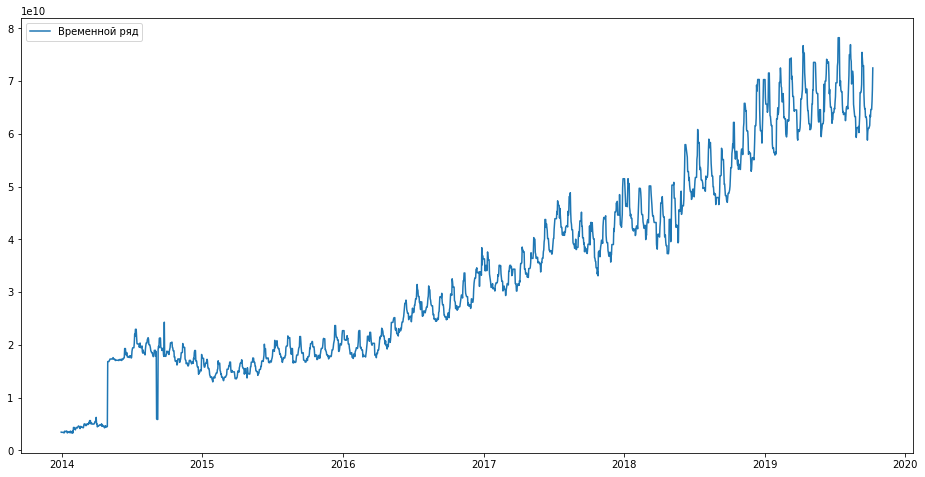

In [7]:
show_time_series(df['VALUE'])

In [8]:
def cum_mean(data, window, num_periods):
    assert window % 2 == 1, 'Размер окна четный'
    n = len(data)
    periods = []
    cum_mean = []
    step = int(np.ceil(n/num_periods))
    for i in range(0, num_periods):
        periods.append(data[step*i:min(n,step*(i+1) )])
        
    for ts in periods:
        cum_ts = []

        for i in range(len(ts)-window+1):
            cum_ts.append(ts[i:i+window-1].mean())
        mean_Tp = (cum_ts[-1]/cum_ts[0])**(1/(len(cum_ts)-1))
        for i in range(window//2):
            
            cum_ts = [cum_ts[0]/mean_Tp] + cum_ts + [cum_ts[-1]*mean_Tp]
        cum_mean.append(cum_ts)
       

    return np.array(cum_mean, dtype=np.ndarray), np.array(periods, dtype=np.ndarray)

In [9]:

cummean, periods = cum_mean(df['VALUE'], window=CONFIG.window, num_periods=CONFIG.num_periods)
df_cummean = []
for i in cummean:
    df_cummean.extend(list(i))
df['cum_mean'] = df_cummean

In [10]:
def show_ts_cum(data, cum):
    plt.figure(figsize=(16, 8))
    plt.plot(data.index, data, label='Временной ряд')
    plt.plot(cum, color='red', label='Кумулятивное среднее')
    plt.legend()
    plt.show()

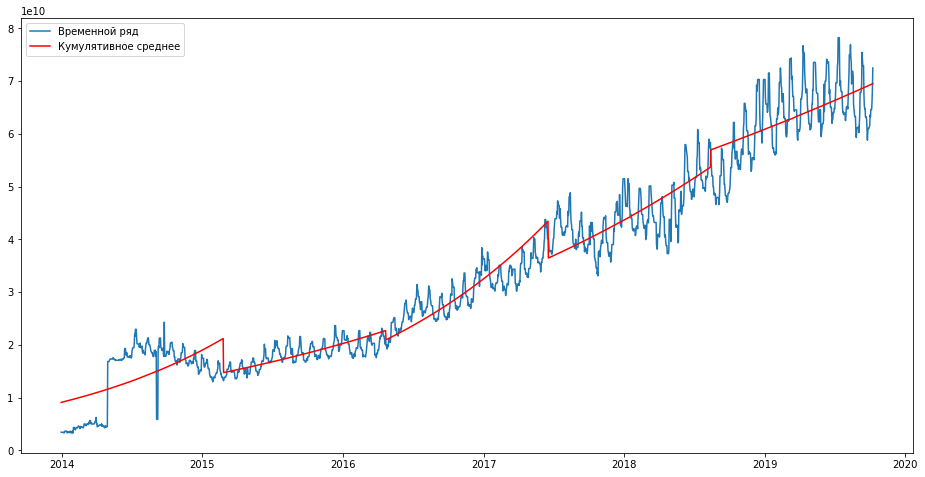

In [11]:
show_ts_cum(df['VALUE'], df['cum_mean'])

Определение сезонной компоненты

In [12]:
season_add, season_mul = [], []
for i in range(CONFIG.num_periods):
    season_add.append((periods[i] - cummean[i]))
    season_mul.append((periods[i] / cummean[i]))
#df['season_add'] = (df['VALUE'] - df['cum_mean'] ).values
#df['season_mul'] = (df['VALUE'] / df['cum_mean'] ).values

In [13]:
season_add = np.array(season_add)
season_mul = np.array(season_mul)

season_add_mean = season_add.mean(axis=0)
season_mul_mean = season_mul.mean(axis=0)

In [14]:
season_add_mean.mean(), season_mul_mean.mean()

(-345637166.73373264, 0.9848103600465561)

In [15]:
season_add_mean = season_add_mean - season_add_mean.mean()
season_mul_mean = season_mul_mean / season_mul_mean.mean()

In [16]:
def get_smean(data, num_periods):
    n = len(data)
    s_mean = []
    
    step = int(np.ceil(n/num_periods))
    for i in range(step):
        step_mean = []
        k = i
        while k < n:
            
            step_mean.append(data[k])
            k = step+k
        s_mean.append(np.mean(step_mean))
    return s_mean
        

In [17]:
#df['smean_add'] = get_smean(df['season_add'], num_periods=CONFIG.num_periods)
df['smean_add'] = list(season_add_mean)*CONFIG.num_periods
df['smean_mul'] = list(season_mul_mean)*CONFIG.num_periods

In [18]:
df['smean_add'].sum(), df['smean_mul'].sum()

(0.000152587890625, 2109.9999999999964)

In [19]:
#Устранение сезонной компоненты

In [20]:
df['NEWVALUE_add'] = df['VALUE'] - df['smean_add']
df['NEWVALUE_mul'] = df['VALUE'] / df['smean_mul']

In [21]:
df.head()

,REPORTDATE,VALUE,cum_mean,smean_add,smean_mul,NEWVALUE_add,NEWVALUE_mul
REPORTDATE,,,,,,,
2013-12-30,2013-12-30,3457625638,9.090775e+09,-6.121761e+08,0.877550,4.069802e+09,3.940091e+09
2013-12-31,2013-12-31,3417092149,9.109076e+09,-1.298111e+09,0.864632,4.715203e+09,3.952078e+09
2014-01-01,2014-01-01,3417092149,9.127413e+09,-1.714438e+09,0.858574,5.131531e+09,3.979962e+09
2014-01-02,2014-01-02,3417092149,9.145788e+09,-2.082740e+09,0.847654,5.499832e+09,4.031237e+09
2014-01-03,2014-01-03,3417092149,9.164199e+09,-2.009603e+09,0.852957,5.426695e+09,4.006173e+09


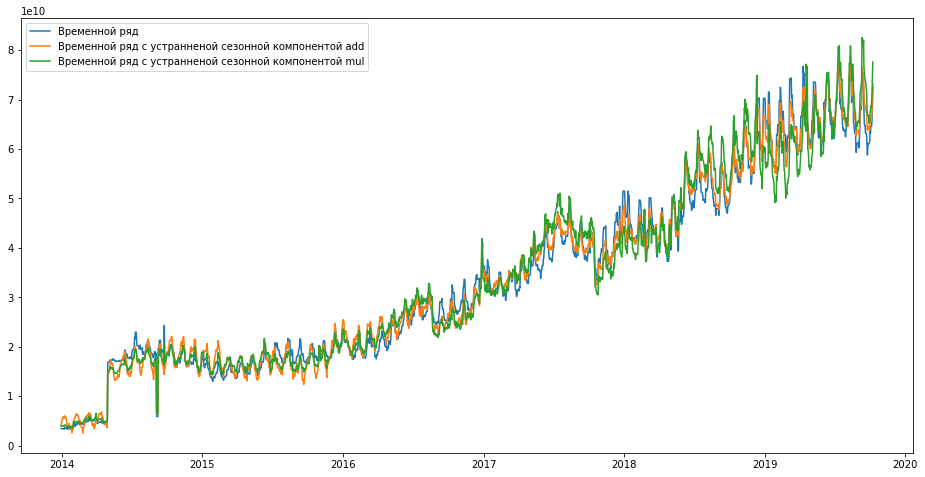

In [22]:
show_time_series(df['VALUE'], show=False)
show_time_series(df['NEWVALUE_add'], label='Временной ряд с устранненой сезонной компонентой add', second_=True, show=False)
show_time_series(df['NEWVALUE_mul'], label='Временной ряд с устранненой сезонной компонентой mul', second_=True)

In [23]:
#Определение тренда
def method_analytic_level( data):
    t = np.arange(1, data.shape[0]+1)
    b = float(((data*t).mean()- data.mean()*t.mean())/t.var())
    print(t.var())
    a = data.mean() - b*(t.mean())
    
    return a + b*t, a, b

df['trend_add'], a_add, b_add = method_analytic_level(df['NEWVALUE_add'])
df['trend_mul'], a_mul, b_mul = method_analytic_level(df['NEWVALUE_mul'])
df.head()

371008.25
371008.25


,REPORTDATE,VALUE,cum_mean,smean_add,smean_mul,NEWVALUE_add,NEWVALUE_mul,trend_add,trend_mul
REPORTDATE,,,,,,,,,
2013-12-30,2013-12-30,3457625638,9.090775e+09,-6.121761e+08,0.877550,4.069802e+09,3.940091e+09,2.660585e+09,2.593477e+09
2013-12-31,2013-12-31,3417092149,9.109076e+09,-1.298111e+09,0.864632,4.715203e+09,3.952078e+09,2.690190e+09,2.623267e+09
2014-01-01,2014-01-01,3417092149,9.127413e+09,-1.714438e+09,0.858574,5.131531e+09,3.979962e+09,2.719794e+09,2.653056e+09
2014-01-02,2014-01-02,3417092149,9.145788e+09,-2.082740e+09,0.847654,5.499832e+09,4.031237e+09,2.749399e+09,2.682845e+09
2014-01-03,2014-01-03,3417092149,9.164199e+09,-2.009603e+09,0.852957,5.426695e+09,4.006173e+09,2.779003e+09,2.712634e+09


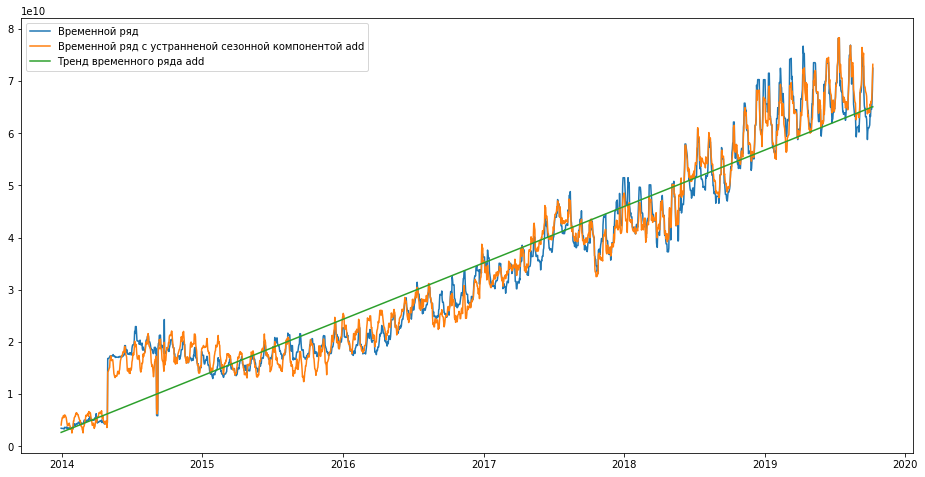

In [24]:
show_time_series(df['VALUE'], show=False)
show_time_series(df['NEWVALUE_add'], label='Временной ряд с устранненой сезонной компонентой add', second_=True, show=False)
show_time_series(df['trend_add'], label='Тренд временного ряда add', second_=True)

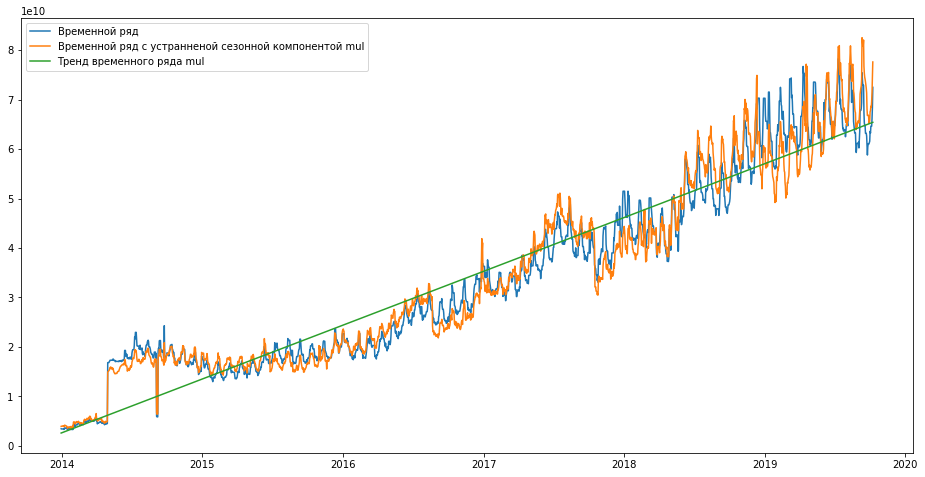

In [25]:
show_time_series(df['VALUE'], show=False)
show_time_series(df['NEWVALUE_mul'], label='Временной ряд с устранненой сезонной компонентой mul', second_=True, show=False)
show_time_series(df['trend_mul'], label='Тренд временного ряда mul', second_=True)

In [26]:
# Y = T + S + E
df['PREDVALUE_add'] = df['smean_add'] + df['trend_add']

In [27]:
# Y = T * S * E
df['PREDVALUE_mul'] = df['smean_mul'] * df['trend_mul']

In [28]:
df['trend_mul']

REPORTDATE
2013-12-30    2.593477e+09
2013-12-31    2.623267e+09
2014-01-01    2.653056e+09
2014-01-02    2.682845e+09
2014-01-03    2.712634e+09
                  ...     
2019-10-05    6.529983e+10
2019-10-06    6.532962e+10
2019-10-07    6.535941e+10
2019-10-08    6.538920e+10
2019-10-09    6.541899e+10
Name: trend_mul, Length: 2110, dtype: float64

In [29]:
df['trend_add']

REPORTDATE
2013-12-30    2.660585e+09
2013-12-31    2.690190e+09
2014-01-01    2.719794e+09
2014-01-02    2.749399e+09
2014-01-03    2.779003e+09
                  ...     
2019-10-05    6.497794e+10
2019-10-06    6.500755e+10
2019-10-07    6.503715e+10
2019-10-08    6.506675e+10
2019-10-09    6.509636e+10
Name: trend_add, Length: 2110, dtype: float64

In [30]:
df['smean_mul']

REPORTDATE
2013-12-30    0.877550
2013-12-31    0.864632
2014-01-01    0.858574
2014-01-02    0.847654
2014-01-03    0.852957
                ...   
2019-10-05    0.944419
2019-10-06    0.928515
2019-10-07    0.925687
2019-10-08    0.915891
2019-10-09    0.933921
Name: smean_mul, Length: 2110, dtype: float64

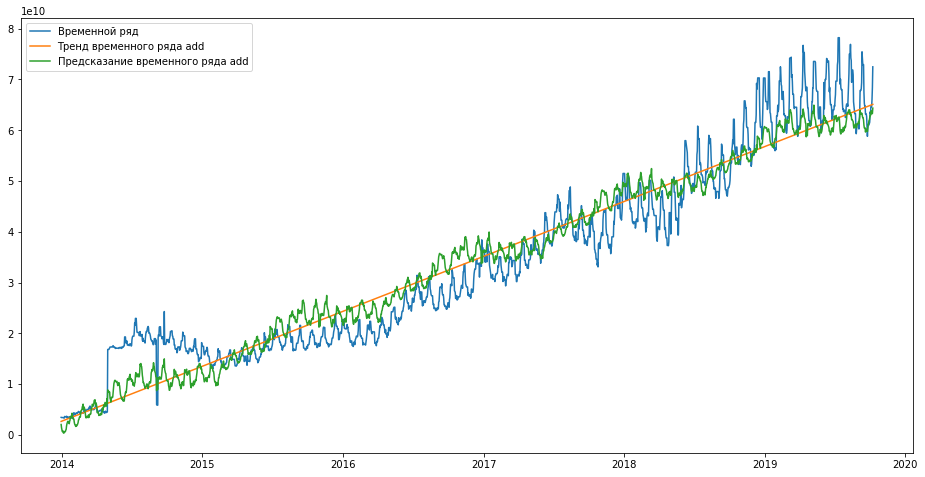

In [31]:
show_time_series(df['VALUE'], show=False)
show_time_series(df['trend_add'], label='Тренд временного ряда add', second_=True, show=False)
show_time_series(df['PREDVALUE_add'], label='Предсказание временного ряда add', second_=True)

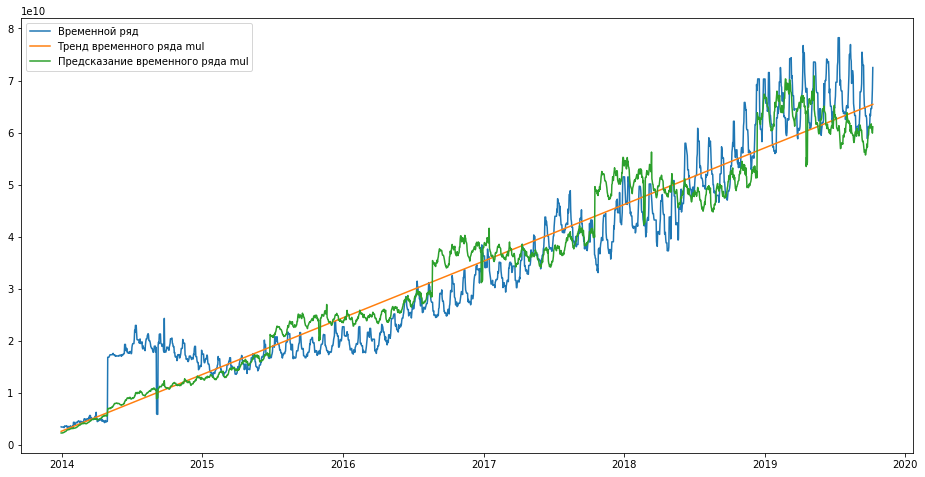

In [32]:
show_time_series(df['VALUE'], show=False)
show_time_series(df['trend_mul'], label='Тренд временного ряда mul', second_=True, show=False)
show_time_series(df['PREDVALUE_mul'], label='Предсказание временного ряда mul', second_=True)

In [33]:
#Измерение качества на обучающей выборке

In [34]:
r2_add = r2_score(df['VALUE'], df['PREDVALUE_add'])
print('R2 for add model =', r2_add)

R2 for add model = 0.9231986469247911


In [35]:
r2_mul = r2_score(df['VALUE'], df['PREDVALUE_mul'])
print('R2 for mul model =', r2_mul)

R2 for mul model = 0.9019017096438842


In [36]:
#предсказания на новый период
new_values = df.iloc[-1, -2]+ a_add+ b_add*(np.arange(len(season_add_mean))+1) + season_add_mean

In [37]:
mape(df['VALUE'], df['PREDVALUE_mul']), mape(df['VALUE'], df['PREDVALUE_add'])

(0.1715956874054072, 0.16866449629855393)